<a href="https://colab.research.google.com/github/marcellosusanto11/Tugas-Deep-Learning/blob/master/predict_digit/modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
# Set working directory
%cd drive/My\ Drive/Colab\ Notebooks/Tugas\ Deep \Learning\ III

/content/drive/My Drive/Colab Notebooks/Tugas Deep Learning III


In [0]:
# Install package


In [0]:
# Setting package umum 
import pandas as pd
import pandas_profiling as pp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

# Specific package
import torch

from matplotlib.pylab import rcParams
# For every plotting cell use this
# grid = gridspec.GridSpec(n_row,n_col)
# ax = plt.subplot(grid[i])
# fig, axes = plt.subplots()
rcParams['figure.figsize'] = [10,5]
plt.style.use('fivethirtyeight') 
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.options.display.float_format = '{:.4f}'.format

## Function
This cell contain all the function used in this kernel including the NeuralNetwork class

In [0]:
## Activation Function

# Sigmoid
def sigmoid(s) :
  return 1 / (1 + torch.exp(-s))

# Derivate of Sigmoid
def der_sigmoid(s) :
  return s * (1 - s)

# Derivative of MSE based on Sigmoid
def der_sigmoid_mse(s, y) :
  return (s - y) * s * (1 - s)
  
# Tanh
def tanh(s) :
  return torch.tanh(s)

# Derivate of Tanh
def der_tanh(s) :
  return 1 - s**2

# Softmax
def softmax(s) :
  exps = torch.exp(s - torch.max(s, axis = 1, keepdims = True)[0])
  return exps / torch.sum(exps, axis = 1, keepdims = True)

# Derivative of Softmax based on Cross Entropy
def der_softmax_ce(s, y) :
  return s - y

In [0]:
# Make ANN Class
class NeuralNetwork() :

  # Variable initiation
  def __init__(self, x, y, hl_act, ol_act, der_hl_act, der_ol_act, opt='None', hl1_dims=784, hl2_dims=784, alpha=1, scaler=None, m_coeff=0.8, beta1=0.9, beta2=0.999):

    # Variable to do standarization and normalization
    self.maxx  = np.max(x)
    self.minx = np.min(x)
    self.meanx = np.mean(x)
    self.stdx  = np.std(x)

    # Variable to modify the ANN
    self.scaler = scaler #Scale predictor or not
    self.y = torch.from_numpy(y).float()
    self.opt = opt
    self.m_coeff = m_coeff
    self.beta1 = beta1
    self.beta2 = beta2
    self.alpha = alpha #Learning rate
    self.hl1 = hl1_dims #Total neuron in Hidden Layer I
    self.hl2 = hl2_dims #Total neuron in Hidden Layer II

    # Define activation function used in this model
    self.hl_act = hl_act
    self.ol_act = ol_act
    self.der_hl_act = der_hl_act
    self.der_ol_act = der_ol_act
    
    # Scale the predictor
    self.X = self.make_X(x)
    
    # Initiate seed
    # NIM : 10116017
    torch.manual_seed(10116017)

    # Define dataset dimension
    No = self.y.shape[1]

    # Initiate weight and bias
    self.w0 = torch.randn(64,self.hl1)
    self.b0 = torch.randn(1,self.hl1)
    self.w1 = torch.randn(self.hl1,self.hl2)
    self.b1 = torch.randn(1,self.hl2)
    self.w2 = torch.randn(self.hl2,No)
    self.b2 = torch.randn(1,No)

    # For NesterovMomentum and Adam
    self.dw0 = torch.zeros(64,self.hl1)
    self.db0 = torch.zeros(1,self.hl1)
    self.dw1 = torch.zeros(self.hl1,self.hl2)
    self.db1 = torch.zeros(1,self.hl2)
    self.dw2 = torch.zeros(self.hl2,No)
    self.db2 = torch.zeros(1,No)

    # For RMSProp and Adam
    self.ew0 = torch.zeros(1,1)
    self.eb0 = torch.zeros(1,1)
    self.ew1 = torch.zeros(1,1)
    self.eb1 = torch.zeros(1,1)
    self.ew2 = torch.zeros(1,1)
    self.eb2 = torch.zeros(1,1)
    
  # Function to do feature scaling
  def make_X(self, X) :
    if self.scaler == 'norm' :
      # Normalization
      X = (X - self.minx) / (self.maxx - self.minx)
    elif self.scaler == 'standard' :
      # Standarization
      X = (X - self.meanx) / self.stdx

    return torch.from_numpy(X).float()

  # Function to do forward propagation train
  def forward_train(self):
    self.A0 = self.X

    # Input Layer -> Hidden Layer 1
    Z1      = torch.mm(self.A0, self.w0) + self.b0 
    self.A1 = self.hl_act(Z1)

    # Hidden Layer 1 -> Hidden Layer 2
    Z2      = torch.mm(self.A1, self.w1) + self.b1
    self.A2 = self.hl_act(Z2)

    # Hidden Layer 2 -> Output Layer
    Z3      = torch.mm(self.A2, self.w2) + self.b2
    self.A3 = self.ol_act(Z3) 

  # Function to do forward propagation predict
  def forward_predict(self):

    # Input Layer -> Hidden Layer 1
    Z1      = torch.mm(self.xs, self.w0) + self.b0 
    self.A1_pred = self.hl_act(Z1)

    # Hidden Layer 1 -> Hidden Layer 2
    Z2      = torch.mm(self.A1_pred, self.w1) + self.b1
    self.A2_pred = self.hl_act(Z2)

    # Hidden Layer 2 -> Output Layer
    Z3      = torch.mm(self.A2_pred, self.w2) + self.b2
    self.A3_pred = self.ol_act(Z3) 

  # Function to do backward propagation
  def backward_normal(self):

    # Derivative of loss function and activation function
    e        = self.der_ol_act(self.A3, self.y)
    delta3   = e/e.shape[0]  # delta_w2
    delta2   = torch.mm(delta3, self.w2.t()) * self.der_hl_act(self.A2) # delta_w1
    delta1   = torch.mm(delta2, self.w1.t()) * self.der_hl_act(self.A1) # delta_w0

    # Update parameter
    self.w2 -= self.alpha * torch.mm(self.A2.t(), delta3)
    self.b2 -= self.alpha * torch.sum(delta3, axis = 0, keepdims = True)
    self.w1 -= self.alpha * torch.mm(self.A1.t(), delta2)
    self.b1 -= self.alpha * torch.sum(delta2, axis = 0, keepdims = True)
    self.w0 -= self.alpha * torch.mm(self.A0.t(), delta1)
    self.b0 -= self.alpha * torch.sum(delta1, axis = 0, keepdims = True)

  # Function to do backward propagation using NesterovMomentum
  def backward_NM(self) : 

    # Make the fake weight and bias
    self.fake_w2 = self.w2 - self.m_coeff * self.dw2
    self.fake_b2 = self.b2 - self.m_coeff * self.db2
    self.fake_w1 = self.w1 - self.m_coeff * self.dw1
    self.fake_b1 = self.b1 - self.m_coeff * self.db1
    self.fake_w0 = self.w0 - self.m_coeff * self.dw0
    self.fake_b0 = self.b0 - self.m_coeff * self.db0

    # Fake forward propagation
    # Input Layer -> Hidden Layer 1
    fake_Z1      = torch.mm(self.A0, self.fake_w0) + self.fake_b0 
    self.fake_A1 = self.hl_act(fake_Z1)

    # Hidden Layer 1 -> Hidden Layer 2
    fake_Z2      = torch.mm(self.A1, self.fake_w1) + self.fake_b1
    self.fake_A2 = self.hl_act(fake_Z2)

    # Hidden Layer 2 -> Output Layer
    fake_Z3      = torch.mm(self.A2, self.fake_w2) + self.fake_b2
    self.fake_A3 = self.ol_act(fake_Z3) 

    # Derivative of loss function and activation function
    e        = self.der_ol_act(self.fake_A3, self.y)
    delta3   = e/e.shape[0]  # delta_w2
    delta2   = torch.mm(delta3, self.fake_w2.t()) * self.der_hl_act(self.A2) # delta_w1
    delta1   = torch.mm(delta2, self.fake_w1.t()) * self.der_hl_act(self.A1) # delta_w0

    # Update the derivative for NesterovMomentum
    self.dw2 = self.m_coeff * self.dw2 + self.alpha * torch.mm(self.A2.t(), delta3)
    self.db2 = self.m_coeff * self.db2 + self.alpha * torch.sum(delta3, axis = 0, keepdims = True)
    self.dw1 = self.m_coeff * self.dw1 + self.alpha * torch.mm(self.A1.t(), delta2)
    self.db1 = self.m_coeff * self.db1 + self.alpha * torch.sum(delta2, axis = 0, keepdims = True)
    self.dw0 = self.m_coeff * self.dw0 + self.alpha * torch.mm(self.A0.t(), delta1)
    self.db0 = self.m_coeff * self.db0 + self.alpha * torch.sum(delta1, axis = 0, keepdims = True)

    # Update parameter
    self.w2 -= self.dw2
    self.b2 -= self.db2
    self.w1 -= self.dw1
    self.b1 -= self.db1
    self.w0 -= self.dw0
    self.b0 -= self.db0

  # Function to do backward propagation using RMSProp
  def backward_RMSProp(self) : 

    # Derivative of loss function and activation function
    e        = self.der_ol_act(self.A3, self.y)
    delta3   = e/e.shape[0]  # delta_w2
    delta2   = torch.mm(delta3, self.w2.t()) * self.der_hl_act(self.A2) # delta_w1
    delta1   = torch.mm(delta2, self.w1.t()) * self.der_hl_act(self.A1) # delta_w0

    temp_dw2 = torch.mm(self.A2.t(), delta3)
    temp_db2 = torch.sum(delta3, axis = 0, keepdims = True)
    temp_dw1 = torch.mm(self.A1.t(), delta2)
    temp_db1 = torch.sum(delta2, axis = 0, keepdims = True)
    temp_dw0 = torch.mm(self.A0.t(), delta1)
    temp_db0 = torch.sum(delta1, axis = 0, keepdims = True)

    # Update the derivative for RMSProp
    self.ew2 = self.m_coeff * self.ew2 + (1 - self.m_coeff) * temp_dw2 ** 2
    self.eb2 = self.m_coeff * self.eb2 + (1 - self.m_coeff) * temp_db2 ** 2
    self.ew1 = self.m_coeff * self.ew1 + (1 - self.m_coeff) * temp_dw1 ** 2
    self.eb1 = self.m_coeff * self.eb1 + (1 - self.m_coeff) * temp_db1 ** 2
    self.ew0 = self.m_coeff * self.ew0 + (1 - self.m_coeff) * temp_dw0 ** 2
    self.eb0 = self.m_coeff * self.eb0 + (1 - self.m_coeff) * temp_db0 ** 2

    # Update parameter
    e_rms = 0.00000001
    self.w2 -= (self.alpha / torch.sqrt(self.ew2 + e_rms )) * temp_dw2
    self.b2 -= (self.alpha / torch.sqrt(self.eb2 + e_rms )) * temp_db2
    self.w1 -= (self.alpha / torch.sqrt(self.ew1 + e_rms )) * temp_dw1
    self.b1 -= (self.alpha / torch.sqrt(self.eb1 + e_rms )) * temp_db1
    self.w0 -= (self.alpha / torch.sqrt(self.ew0 + e_rms )) * temp_dw0
    self.b0 -= (self.alpha / torch.sqrt(self.eb0 + e_rms )) * temp_db0

  # Function to do backward propagation using RMSProp
  def backward_Adam(self, epoch) : 

    # Initiate params
    beta1 = self.beta1
    beta2 = self.beta2
    e_adam = 0.00000001

    # Derivative of loss function and activation function
    e        = self.der_ol_act(self.A3, self.y)
    delta3   = e/e.shape[0]  # delta_w2
    delta2   = torch.mm(delta3, self.w2.t()) * self.der_hl_act(self.A2) # delta_w1
    delta1   = torch.mm(delta2, self.w1.t()) * self.der_hl_act(self.A1) # delta_w0

    temp_dw2 = torch.mm(self.A2.t(), delta3)
    temp_db2 = torch.sum(delta3, axis = 0, keepdims = True)
    temp_dw1 = torch.mm(self.A1.t(), delta2)
    temp_db1 = torch.sum(delta2, axis = 0, keepdims = True)
    temp_dw0 = torch.mm(self.A0.t(), delta1)
    temp_db0 = torch.sum(delta1, axis = 0, keepdims = True)

    # Calculate first moment
    self.dw2 = beta1  * self.dw2 + (1 - beta1) * temp_dw2
    self.db2 = beta1  * self.db2 + (1 - beta1) * temp_db2
    self.dw1 = beta1  * self.dw1 + (1 - beta1) * temp_dw1
    self.db1 = beta1  * self.db1 + (1 - beta1) * temp_db1
    self.dw0 = beta1  * self.dw0 + (1 - beta1) * temp_dw0
    self.db0 = beta1  * self.db0 + (1 - beta1) * temp_db0

    # Calculate the second moment
    self.ew2 = beta2 * self.ew2 + (1 - beta2) * temp_dw2 ** 2
    self.eb2 = beta2 * self.eb2 + (1 - beta2) * temp_db2 ** 2
    self.ew1 = beta2 * self.ew1 + (1 - beta2) * temp_dw1 ** 2
    self.eb1 = beta2 * self.eb1 + (1 - beta2) * temp_db1 ** 2
    self.ew0 = beta2 * self.ew0 + (1 - beta2) * temp_dw0 ** 2
    self.eb0 = beta2 * self.eb0 + (1 - beta2) * temp_db0 ** 2

    # Calculate the expected first and second moment
    exp_dw2 = self.dw2 / (1 - beta1 ** (epoch+1))
    exp_db2 = self.db2 / (1 - beta1 ** (epoch+1))
    exp_dw1 = self.dw1 / (1 - beta1 ** (epoch+1))
    exp_db1 = self.db1 / (1 - beta1 ** (epoch+1))
    exp_dw0 = self.dw0 / (1 - beta1 ** (epoch+1))
    exp_db0 = self.db0 / (1 - beta1 ** (epoch+1))

    exp_ew2 = self.ew2 / (1 - beta2 ** (epoch+1))
    exp_eb2 = self.eb2 / (1 - beta2 ** (epoch+1))
    exp_ew1 = self.ew1 / (1 - beta2 ** (epoch+1))
    exp_eb1 = self.eb1 / (1 - beta2 ** (epoch+1))
    exp_ew0 = self.ew0 / (1 - beta2 ** (epoch+1))
    exp_eb0 = self.eb0 / (1 - beta2 ** (epoch+1))

    # Update parameter
    self.w2 -= (self.alpha / (exp_ew2 ** 0.5 + e_adam)) * exp_dw2
    self.b2 -= (self.alpha / (exp_eb2 ** 0.5 + e_adam)) * exp_db2
    self.w1 -= (self.alpha / (exp_ew1 ** 0.5 + e_adam)) * exp_dw1
    self.b1 -= (self.alpha / (exp_eb1 ** 0.5 + e_adam)) * exp_db1
    self.w0 -= (self.alpha / (exp_ew0 ** 0.5 + e_adam)) * exp_dw0
    self.b0 -= (self.alpha / (exp_eb0 ** 0.5 + e_adam)) * exp_db0

  # Function to choose optimizer 
  def backward(self, epoch) :
    if self.opt == 'None' :
      self.backward_normal()
    elif self.opt == 'NM' :
      self.backward_NM()
    elif self.opt == 'RMSProp' :
      self.backward_RMSProp()
    elif self.opt == 'Adam' :
      self.backward_Adam(epoch)

  # Function to predict
  def predict(self,xs):

    # Scaling
    self.xs = self.make_X(xs)

    # Calculate
    self.forward_predict()

    # Predict
    predict = torch.argmax(self.A3_pred, axis = 1)

    return predict

In [0]:
# Function to compile everything
# Including the viz
def go_ann(ann, X_train, y_train, X_test, y_test, ax, title, iter) :

  # Start time
  from datetime import datetime
  tic = datetime.now()

  # Define list to store accuracy from each epoch
  list_train_acc = []
  list_test_acc = []
  list_epochs = []

  # Iterate to training
  for i in range(epochs):

    # Forward and backward propagation
    ann.forward_train()
    ann.backward(i)

    # Caclculate accuracy for each iter epoch
    if i%iter == 0:

      # Calculate train accuracy
      prediksi_train = ann.predict(X_train)
      match_train    = np.sum((prediksi_train.cpu().numpy() == np.argmax(y_train, axis = 1))*1)
      akurasi_train  = np.round(np.sum(match_train)/len(y_train)*100, 4)

      # Calculate test accuracy
      prediksi_test = ann.predict(X_test)
      match_test  = np.sum((prediksi_test.cpu().numpy() == np.argmax(y_test, axis = 1))*1)
      akurasi_test = np.round(np.sum(match_test)/len(y_test)*100, 4)

      # Print the output
      print("Iterasi ke :", i,'||','Accuracy Train :',akurasi_train,'||','Accuracy Test :',akurasi_test)
      list_train_acc.append(akurasi_train)
      list_test_acc.append(akurasi_test)
      list_epochs.append(i)

  # End time
  toc = datetime.now()

  # Total time needed to modelling
  print ("Waktu yang diperlukan:", toc-tic)
  print('')

  # Plotting
  ax.plot(list_epochs, list_train_acc, 'o-', label='Train')
  ax.plot(list_epochs, list_test_acc, 'o-', label='Test')
  ax.set_title(title, fontsize=15)
  ax.set_xlabel('Epochs', fontsize=15)
  ax.set_ylabel('Accuracy', fontsize=15)
  ax.legend() ;

  return list_train_acc, list_test_acc, list_epochs

## Preprocess Data

In [0]:
# Load dataset
import pickle
digit = pickle.load(open("digits.dat", "rb"))

In [0]:
# Make the dataframe
df = pd.DataFrame(digit['data'])
df['Y'] = digit['target']

In [0]:
# Shuffle dataset
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['Y'])

In [0]:
# Split the predictor and response
train_df_X = train_df.iloc[:,:-1].values
train_df_y = np.array(pd.get_dummies(train_df['Y']))

test_df_X = test_df.iloc[:,:-1].values
test_df_y = np.array(pd.get_dummies(test_df['Y']))

## Modelling

Iterasi ke : 0 || Accuracy Train : 18.4412 || Accuracy Test : 17.5
Iterasi ke : 5 || Accuracy Train : 43.6326 || Accuracy Test : 39.7222
Iterasi ke : 10 || Accuracy Train : 65.2749 || Accuracy Test : 61.9444
Iterasi ke : 15 || Accuracy Train : 79.4015 || Accuracy Test : 76.9444
Iterasi ke : 20 || Accuracy Train : 79.2624 || Accuracy Test : 73.8889
Iterasi ke : 25 || Accuracy Train : 91.1621 || Accuracy Test : 89.1667
Iterasi ke : 30 || Accuracy Train : 88.4482 || Accuracy Test : 86.6667
Iterasi ke : 35 || Accuracy Train : 95.3375 || Accuracy Test : 94.4444
Iterasi ke : 40 || Accuracy Train : 93.1802 || Accuracy Test : 88.8889
Iterasi ke : 45 || Accuracy Train : 97.3556 || Accuracy Test : 92.7778
Waktu yang diperlukan: 0:00:03.319759

Iterasi ke : 0 || Accuracy Train : 18.4412 || Accuracy Test : 17.5
Iterasi ke : 5 || Accuracy Train : 46.3466 || Accuracy Test : 41.6667
Iterasi ke : 10 || Accuracy Train : 72.7209 || Accuracy Test : 69.1667
Iterasi ke : 15 || Accuracy Train : 85.8733 || A

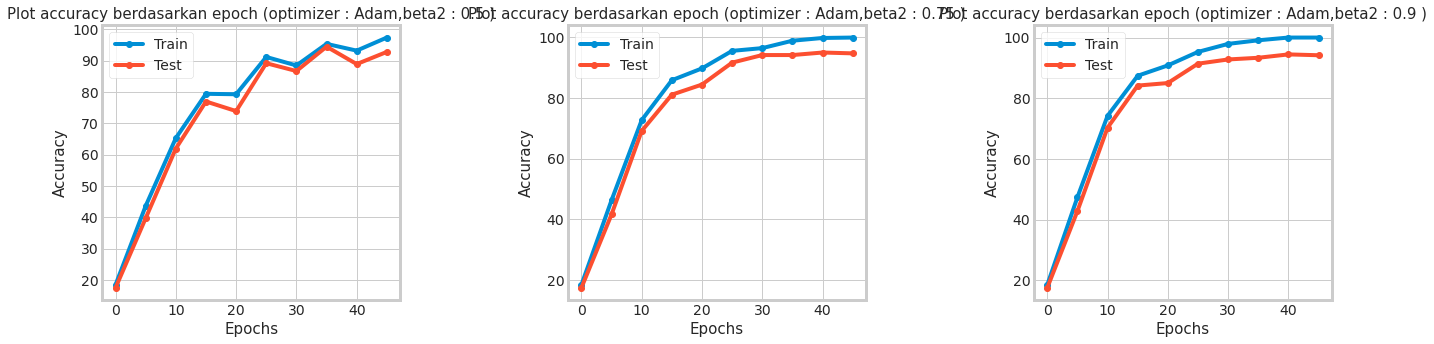

In [90]:
# Plot setting
rcParams['figure.figsize'] = [25,5]
plt.style.use('fivethirtyeight') 
sns.set_style('whitegrid')
list_df = []

# Optimizer modification
list_opt = ['None', 'NM', 'RMSProp', 'Adam']

# Optimizer params modification
list_par = [0.5, 0.75, 0.9]

# For subplot
grid = gridspec.GridSpec(1,len(list_opt))
list_df = []

for j,mod in enumerate(list_par) :

  # Define variable and model parameter
  X_train = train_df_X
  y_train = train_df_y
  X_test = test_df_X
  y_test = test_df_y
  act_func_hidden_layer = sigmoid
  act_func_output_layer = softmax
  der_act_func_hidden_layer = der_sigmoid
  der_act_func_output_layer = der_softmax_ce
  alpha = 0.01
  scaler = 'standard'
  opt = 'Adam'
  m_coeff = 0.9
  beta1 = 0.9
  beta2 = mod

  epochs = 50
  ax = plt.subplot(grid[j])
  ax_title = 'Plot accuracy berdasarkan epoch (optimizer : ' + opt + ',beta2 : ' + str(mod) + ' )'

  # Modelling
  ann_v1 = NeuralNetwork(x = X_train, y = y_train
                    ,hl_act = act_func_hidden_layer
                    ,ol_act = act_func_output_layer
                    ,der_hl_act = der_act_func_hidden_layer
                    ,der_ol_act = der_act_func_output_layer
                    ,opt=opt, m_coeff=m_coeff, beta1=beta1, beta2=beta2
                    ,hl1_dims=256, hl2_dims=256
                    ,alpha = alpha
                    ,scaler = scaler)

  # Go
  train_acc, test_acc, epo = go_ann(ann_v1, X_train, y_train, X_test, y_test, ax, ax_title, 5)

  # Make dataframe
  df = pd.DataFrame({'Train Acc':train_acc, 'Test Acc':test_acc, 'Epoch':epo})

  # Save the dataframe
  list_df.append(df)

plt.tight_layout()

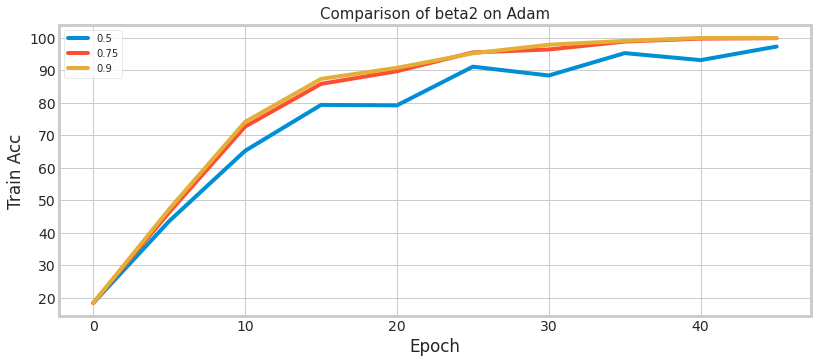

In [91]:
# Compare the training accuracy in one plot
rcParams['figure.figsize'] = [12,5]
plt.style.use('fivethirtyeight') 
sns.set_style('whitegrid')

# Plot
for i,df in enumerate(list_df) :
  sns.lineplot(data=df, x='Epoch', y='Train Acc', label=list_par[i])

# Add cosmetics
plt.title('Comparison of beta2 on Adam', fontsize=15) ;
plt.legend(prop={'size': 10}) ;

Iterasi ke : 0 || Accuracy Train : 8.977 || Accuracy Test : 10.2778
Iterasi ke : 10 || Accuracy Train : 9.0466 || Accuracy Test : 10.0
Iterasi ke : 20 || Accuracy Train : 9.1858 || Accuracy Test : 11.1111
Iterasi ke : 30 || Accuracy Train : 9.3946 || Accuracy Test : 12.2222
Iterasi ke : 40 || Accuracy Train : 9.7425 || Accuracy Test : 13.3333
Iterasi ke : 50 || Accuracy Train : 10.2992 || Accuracy Test : 13.6111
Iterasi ke : 60 || Accuracy Train : 10.8559 || Accuracy Test : 13.0556
Iterasi ke : 70 || Accuracy Train : 11.3431 || Accuracy Test : 13.3333
Iterasi ke : 80 || Accuracy Train : 11.691 || Accuracy Test : 14.4444
Iterasi ke : 90 || Accuracy Train : 12.1086 || Accuracy Test : 14.4444
Waktu yang diperlukan: 0:00:00.400070

Iterasi ke : 0 || Accuracy Train : 8.977 || Accuracy Test : 10.2778
Iterasi ke : 10 || Accuracy Train : 11.9694 || Accuracy Test : 14.4444
Iterasi ke : 20 || Accuracy Train : 11.8998 || Accuracy Test : 13.0556
Iterasi ke : 30 || Accuracy Train : 19.5546 || Accur

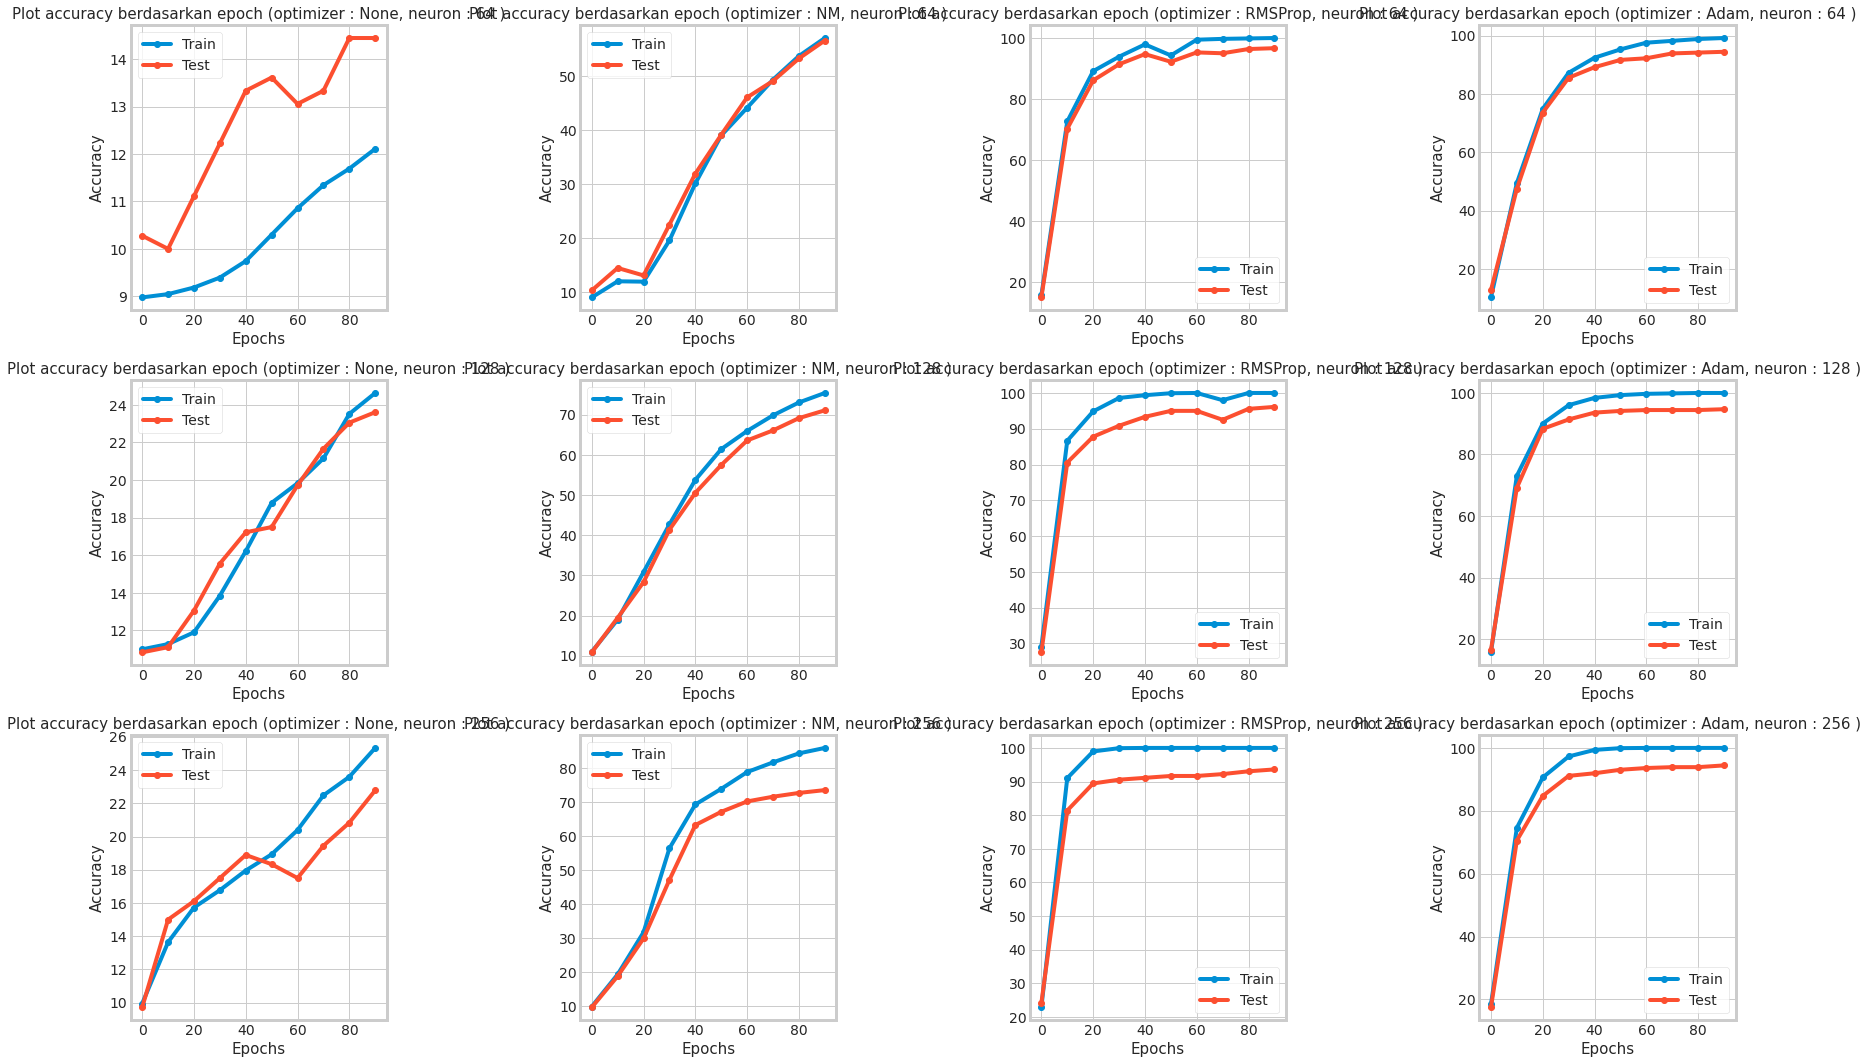

In [56]:
# Plot setting
rcParams['figure.figsize'] = [25,15]
plt.style.use('fivethirtyeight') 
sns.set_style('whitegrid')

# Optimizer modification
list_opt = ['None', 'NM', 'RMSProp', 'Adam']

# Params modification
list_lr = [0.01, 0.1, 0.5]
list_scaler = ['None', 'norm', 'standard']
list_neuron = [64, 128, 256]

# For subplot
grid = gridspec.GridSpec(len(list_neuron),len(list_opt))
list_main_df = []

for z,par in enumerate(list_neuron) :
  list_df = []
  for j,mod in enumerate(list_opt) :

    # Define variable and model parameter
    X_train = train_df_X
    y_train = train_df_y
    X_test = test_df_X
    y_test = test_df_y
    act_func_hidden_layer = sigmoid
    act_func_output_layer = softmax
    der_act_func_hidden_layer = der_sigmoid
    der_act_func_output_layer = der_softmax_ce
    alpha = 0.01
    scaler = 'standard'
    opt = mod
    m_coeff = 0.9
    beta1 = 0.9
    beta2 = 0.999

    epochs = 100
    ax = plt.subplot(grid[z*4 + j])
    ax_title = 'Plot accuracy berdasarkan epoch (optimizer : ' + opt + ', neuron : ' + str(par) + ' )'

    # Modelling
    ann_v1 = NeuralNetwork(x = X_train, y = y_train
                      ,hl_act = act_func_hidden_layer
                      ,ol_act = act_func_output_layer
                      ,der_hl_act = der_act_func_hidden_layer
                      ,der_ol_act = der_act_func_output_layer
                      ,opt=opt, m_coeff=m_coeff, beta1=beta1, beta2=beta2
                      ,hl1_dims=par, hl2_dims=par
                      ,alpha = alpha
                      ,scaler = scaler)

    # Go
    train_acc, test_acc, epo = go_ann(ann_v1, X_train, y_train, X_test, y_test, ax, ax_title, 10)

    # Make dataframe
    df = pd.DataFrame({'Train Acc':train_acc, 'Test Acc':test_acc, 'Epoch':epo})

    # Save the dataframe
    list_df.append(df)

  list_main_df.append(list_df)

plt.tight_layout()

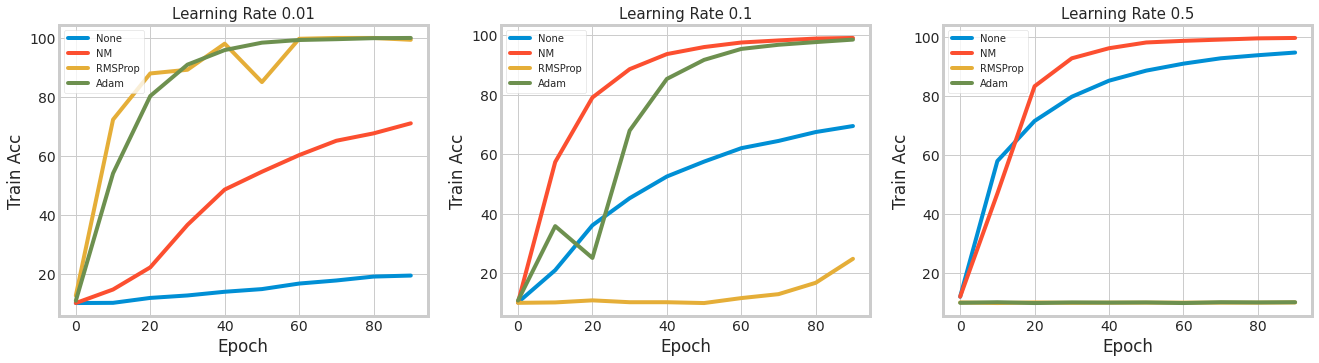

In [50]:
# Compare the training accuracy in one plot
rcParams['figure.figsize'] = [20,5]
plt.style.use('fivethirtyeight') 
sns.set_style('whitegrid')
grid = gridspec.GridSpec(1,len(list_lr))

# Plot 
for j,list_df in enumerate(list_main_df) : 
  ax = plt.subplot(grid[j])
  
  for i,df in enumerate(list_df) :
    sns.lineplot(data=df, x='Epoch', y='Train Acc', label=list_opt[i], ax=ax)
    plt.legend(prop={'size': 10}) ;
    plt.title('Learning Rate ' + str(list_lr[j]), fontsize=15) ;

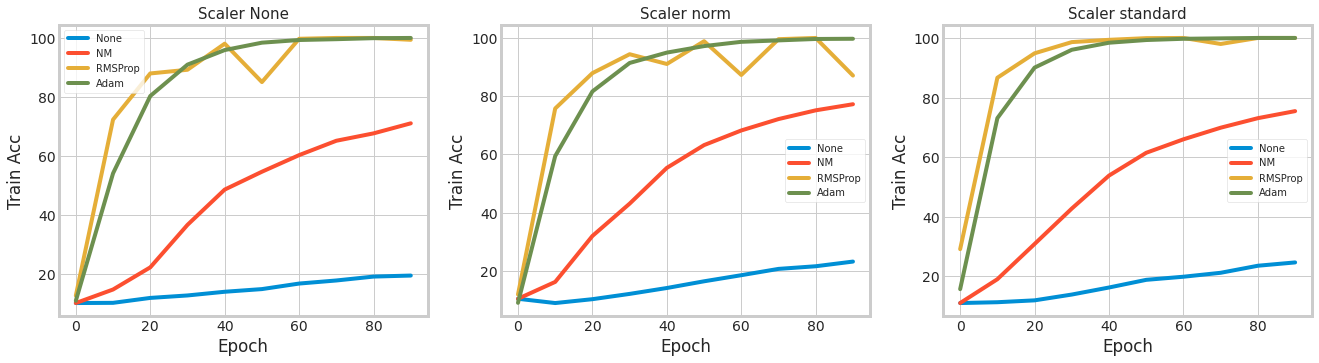

In [53]:
# Compare the training accuracy in one plot
rcParams['figure.figsize'] = [20,5]
plt.style.use('fivethirtyeight') 
sns.set_style('whitegrid')
grid = gridspec.GridSpec(1,len(list_scaler))

# Plot 
for j,list_df in enumerate(list_main_df) : 
  ax = plt.subplot(grid[j])
  
  for i,df in enumerate(list_df) :
    sns.lineplot(data=df, x='Epoch', y='Train Acc', label=list_opt[i], ax=ax)
    plt.legend(prop={'size': 10}) ;
    plt.title('Scaler ' + list_scaler[j], fontsize=15) ;

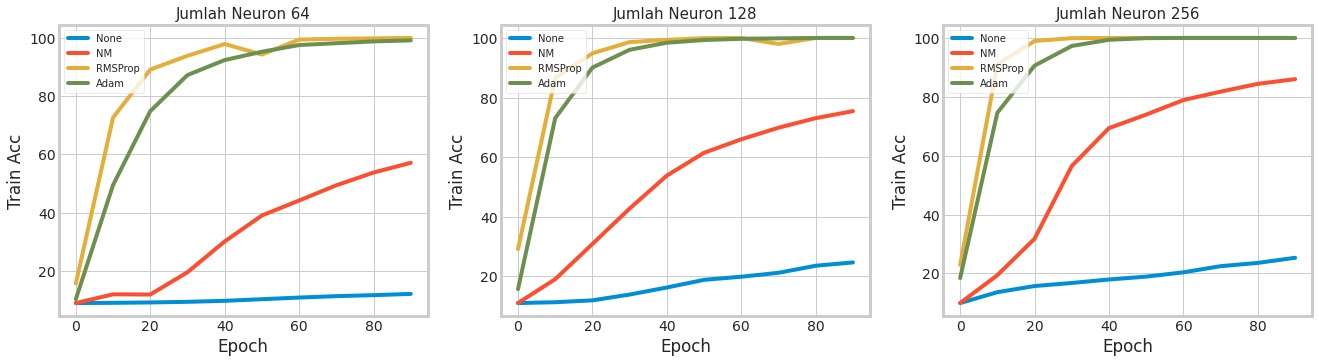

In [59]:
# Compare the training accuracy in one plot
rcParams['figure.figsize'] = [20,5]
plt.style.use('fivethirtyeight') 
sns.set_style('whitegrid')
grid = gridspec.GridSpec(1,len(list_neuron))

# Plot 
for j,list_df in enumerate(list_main_df) : 
  ax = plt.subplot(grid[j])
  
  for i,df in enumerate(list_df) :
    sns.lineplot(data=df, x='Epoch', y='Train Acc', label=list_opt[i], ax=ax)
    plt.legend(loc=2, prop={'size': 10}) ;
    plt.title('Jumlah Neuron ' + str(list_neuron[j]), fontsize=15) ;